In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
from Libraries_functions import *
from tqdm import tqdm
import glob
import ipywidgets as widgets
from IPython.display import display

In [3]:
preprocess_files()

  4%|▍         | 8/200 [00:00<00:02, 76.80it/s]

Processed file ../../Datasets/Test/mixed_sound/mixed_sound10066.wav


100%|██████████| 200/200 [00:02<00:00, 77.03it/s]


## Cargamos el modelo y los datos

In [4]:
# model= VAE.load(PATH_TO_MODEL)

min_max_values= load_min_max(MIN_MAX_VALUES)
spectrograms, file_path = load_form_direc(SPECTROGRAMS_SAVE_DIR)
sampled_specs, sampled_min_max_values, file_path = select_spectrograms(spectrograms, file_path, min_max_values, num_spectrograms=4)
voice_paths= search_voices(file_path)

1
['../../Datasets/Data/tests/mixed_sound5093.wav.npy', '../../Datasets/Data/tests/mixed_sound20293.wav.npy', '../../Datasets/Data/tests/mixed_sound42152.wav.npy', '../../Datasets/Data/tests/mixed_sound46435.wav.npy']
['../../Datasets/Test/voice\\voice5093.wav', '../../Datasets/Test/voice\\voice20293.wav', '../../Datasets/Test/voice\\voice42152.wav', '../../Datasets/Test/voice\\voice46435.wav']


## load from vae_auto_propio

In [5]:
model_name="VAE_weights_build_VAE_Skipp_complejo_loss_0.0_alpha_0.3_dim_2048"
alpha=0.3
latent=2048
learning_rate=0.0001

vae, _=VAE.load_model_complete(sampled_specs,alpha,latent, learning_rate)
# vae=VAE.load_model(sampled_specs,alpha,latent, learning_rate)

vae= VAE.load_model_weights(vae, save_folder= PATH_TO_MODEL, name=f"{model_name}.h5")

signals=vae.predict(sampled_specs)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

c:\Users\javca\anaconda3\envs\Ceiec\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


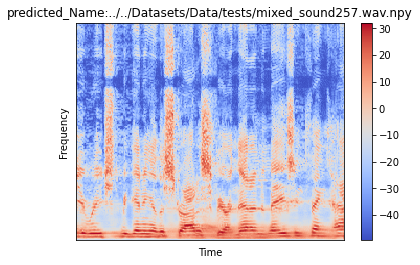

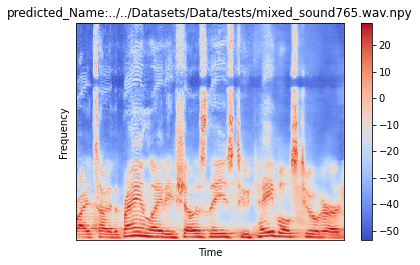

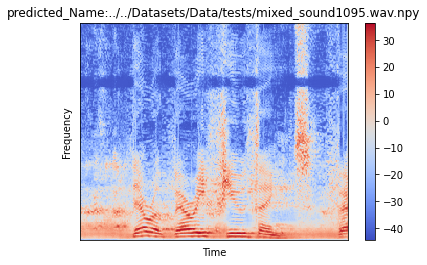

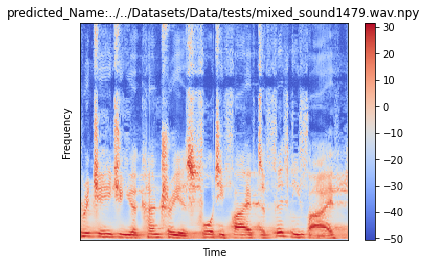

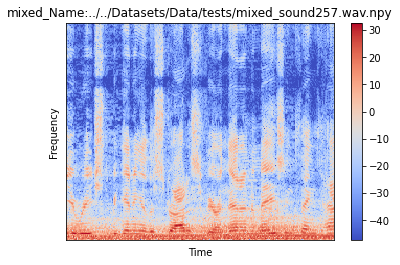

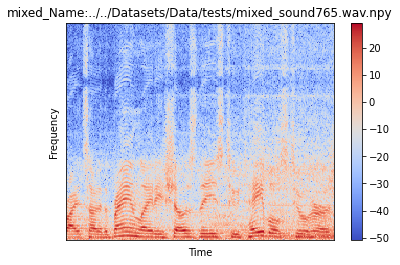

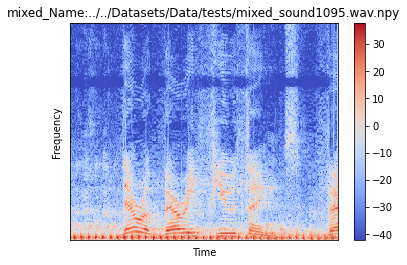

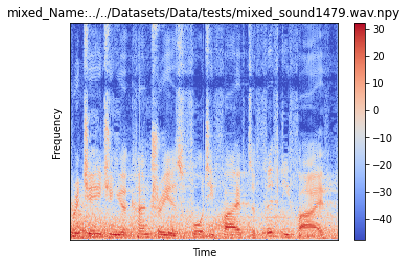

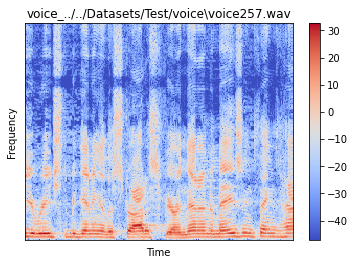

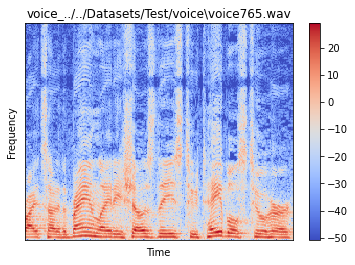

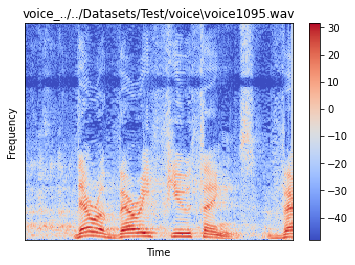

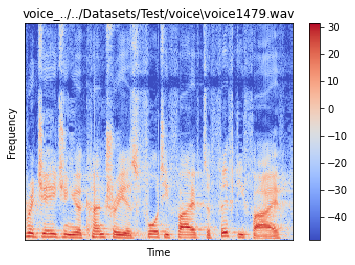

In [6]:
#signals predicted saved on memory
new_signals, predicted_path = convert_spectrograms_to_audio(
    signals, sampled_min_max_values,False,file_path )
#mixed signals saved on memory
original_signals, mixed_path = convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values,True, file_path)
#real signals saved on memory
real_signals, real_path=spectrograms_of_voice(voice_paths)

In [1]:
style = {'description_width': 'initial'}

generating= widgets.Dropdown(
    options=[('Metrics', 0), ('Generate audios', 1)],
    value=1,
    description='Select_metrics or Generate audios',
    style=style,
    layout={'width': 'max-content'}
)
generating_images= widgets.Dropdown(
    options=[('Images', 0), ('No Images', 1)],
    value=1,
    description='Select if generate images or not',
    style=style,
    layout={'width': 'max-content'}
)

display(generating)
display(generating_images)

NameError: name 'widgets' is not defined

In [10]:
if generating.value==1:
    for i in range(len(predicted_path)):
        predicted_path[i]=predicted_path[i].split("d")[-1].split(".")[0]
    for i in range(len(mixed_path)):
        mixed_path[i]=mixed_path[i].split("d")[-1].split(".")[0]
    for i in range(len(real_path)):
        real_path[i]=real_path[i].split("e")[-1].split(".")[0]

    save_signals(new_signals, SAVE_DIR_GENERATED, predicted_path, "predicted_",sample_rate=22050,images=generating_images.value)
    save_signals(original_signals, SAVE_DIR_ORIGINAL, mixed_path, "mixed_",sample_rate=22050,images=generating_images.value)
    save_signals(real_signals, SAVE_DIR_REAL, real_path, "real_",sample_rate=22050,images=generating_images.value)


########################################################################################################################
else:
    #convert list to numpy
    real_signals=np.array(real_signals)
    new_signals=np.array(new_signals)
    original_signals=np.array(original_signals)
    real_signals= real_signals[:,:66045]
    new_signals= new_signals[:,:66045]
    original_signals= original_signals[:,:66045]

########################################################################################################################
# MSE Metrics
    aircrafts=[]
    lluvia=[]
    trafico=[]
    viento=[]

    for i in tqdm(range(new_signals.shape[0])):
        if(i<=new_signals.shape[0]/4-1):
            aircrafts.append(mean_squared_error(real_signals[i],new_signals[i] ))
        elif(i>=new_signals.shape[0]/4 and i<=((new_signals.shape[0]/4)*2)-1):
            lluvia.append(mean_squared_error(real_signals[i],new_signals[i] ))
        elif(i>=((new_signals.shape[0]/4)*2) and i<((new_signals.shape[0]/4)*3)-1):
            trafico.append(mean_squared_error(real_signals[i],new_signals[i] ))
        else:
            viento.append(mean_squared_error( real_signals[i],new_signals[i])) 
    
    df_MSE=pd.DataFrame()
    df_MSE.insert(0,"aircrafts_mean",[mean(aircrafts)])
    df_MSE.insert(1,"aircrafts_desviacion",[desviacion(aircrafts)])

    df_MSE.insert(2,"lluvia_mean",[mean(lluvia)])
    df_MSE.insert(3,"lluvia_desviacion",[desviacion(lluvia)])

    df_MSE.insert(4,"trafico_mean",[mean(trafico)])
    df_MSE.insert(5,"trafico_desviacion",[desviacion(trafico)])

    df_MSE.insert(6,"viento_mean",[mean(viento)])
    df_MSE.insert(7,"viento_desviacion",[desviacion(viento)])

    exception_pesq=0
    aircrafts=[]
    lluvia=[]
    trafico=[]
    viento=[]
    for i in tqdm(range(new_signals.shape[0])):
        #if(i!=139 and i!=157):
        try:
            if(i<=new_signals.shape[0]/4-1):
                aircrafts.append(pesq(16000, real_signals[i], new_signals[i],'wb'))
            elif(i>=new_signals.shape[0]/4 and i<=((new_signals.shape[0]/4)*2)-1):
                lluvia.append(pesq(16000, real_signals[i], new_signals[i],'wb'))
            elif(i>=((new_signals.shape[0]/4)*2) and i<((new_signals.shape[0]/4)*3)-1):
                trafico.append(pesq(16000, real_signals[i],new_signals[i],'wb'))
            else:
                viento.append(pesq(16000, real_signals[i], new_signals[i],'wb'))
        except:
            exception_pesq+=1

    df_pesq=pd.DataFrame()
    df_pesq.insert(0,"aircrafts_mean",[mean(aircrafts)])
    df_pesq.insert(1,"aircrafts_desviacion",[desviacion(aircrafts)])

    df_pesq.insert(2,"lluvia_mean",[mean(lluvia)])
    df_pesq.insert(3,"lluvia_desviacion",[desviacion(lluvia)])

    df_pesq.insert(4,"trafico_mean",[mean(trafico)])
    df_pesq.insert(5,"trafico_desviacion",[desviacion(trafico)])

    df_pesq.insert(6,"viento_mean",[mean(viento)])
    df_pesq.insert(7,"viento_desviacion",[desviacion(viento)])


    exception_snr=0
    aircrafts=[]
    lluvia=[]
    trafico=[]
    viento=[]
    #recibe lo sacado por la red y el mezclado
    for i in tqdm(range(new_signals.shape[0])):
        try:
            if(i<=new_signals.shape[0]/4-1):
                # aircrafts[0].append(signaltonoise(df_data.data[i]))
                # aircrafts[1].append(signaltonoise(df_data.noise_original[i]))
                aircrafts.append(SNRsystem(new_signals[i], original_signals[i]))
            elif(i>=new_signals.shape[0]/4 and i<=((new_signals.shape[0]/4)*2)-1):
                # lluvia[0].append(signaltonoise(df_data.data[i]))
                # lluvia[1].append(signaltonoise(df_data.noise_original[i]))
                lluvia.append(SNRsystem(new_signals[i], original_signals[i]))
            elif(i>=((new_signals.shape[0]/4)*2) and i<((new_signals.shape[0]/4)*3)-1):
                # trafico[0].append(signaltonoise(df_data.data[i]))
                # trafico[1].append(signaltonoise(df_data.noise_original[i]))
                trafico.append(SNRsystem(new_signals[i], original_signals[i]))
            else:
                # viento[0].append(signaltonoise(df_data.data[i]))
                # viento[1].append(signaltonoise(df_data.noise_original[i]))
                viento.append(SNRsystem(new_signals[i], original_signals[i]))
        except:
            exception_snr+=1
    
    df_snr=pd.DataFrame()
    df_snr.insert(0,"aircrafts_mean",[mean(aircrafts)])
    df_snr.insert(1,"aircrafts_desviacion",[desviacion(aircrafts)])

    df_snr.insert(2,"lluvia_mean",[mean(lluvia)])
    df_snr.insert(3,"lluvia_desviacion",[desviacion(lluvia)])

    df_snr.insert(4,"trafico_mean",[mean(trafico)])
    df_snr.insert(5,"trafico_desviacion",[desviacion(trafico)])

    df_snr.insert(6,"viento_mean",[mean(viento)])
    df_snr.insert(7,"viento_desviacion",[desviacion(viento)])

200


200it [00:29,  6.88it/s]


200


200it [00:38,  5.15it/s]


200


200it [00:32,  6.22it/s]


<Figure size 432x288 with 0 Axes>

## MSE

In [20]:
df_MSE

,aircrafts_mean,aircrafts_desviacion,lluvia_mean,lluvia_desviacion,trafico_mean,trafico_desviacion,viento_mean,viento_desviacion
0,0.057543,0.029295,0.069807,0.038784,0.052728,0.014331,0.068027,0.040298


## PESQ

In [21]:
print(exception_pesq)
df_pesq

0


""


## Measuring SNR

### Calculate SNR on 1 signal
Sometimes, the question arises how to get the noise and the Signal separately.
One method is to measure the constant noise power a device *produces without an input*, let's call that $P_n$ and measure the power of the output of a device *with* an input, lets call that $P_s$. By subtraction of the powers, we can estimate the power of the signal alone and therefore the ratio between signal and noise power (assuming noise power stays constant).     

$$ SNR_{db}=10 \cdot \log_{10} \frac {P_s - P_n}{P_n}$$

- $P(s)$ is a function that computes the power of a signal.
- $P_s$ in this case is the power of the signal + the noise, typically the output of the system we want to measure **with** an input signal.
- $P_n$ in this case is the power of just the noise, typically the output of the system we want to measure **without** an input signal.

### Difference between 2 signals
Another method is to try to make the system as clean as possible (eg bypass or similar *at unity gain!*), measure input signal power $P_i$ and output signal power $P_o$ and just assume that the difference between them is the level of noise being added:
$$ P_n = P_o - P_i $$
The rest of the comutation stays the same as Method 1.

## Abstract
When we make the snr of 2 signals, we are measuring the quantity of db that is different in the the original sound vs the noisy sound. This means that we obtain the theorical magnitud of noise.


In [36]:
print(exception_snr)
df_snr ## tener 1db o db negativos en la media, significa que elimina mucho ruido.

24


,aircrafts_mean,aircrafts_desviacion,lluvia_mean,lluvia_desviacion,trafico_mean,trafico_desviacion,viento_mean,viento_desviacion
0,1.377136,4.023724,-1.272899,4.005736,0.512758,1.998994,-0.204366,3.473909


## Comparación de imágenes

In [3]:
image_dict={
    "real":[],
    "predicted":[],
    "mixed":[]
}
path_images_generated="../../Datasets/model_generated_VAE/Images/generated/"
path_images_real="../../Datasets/model_generated_VAE/Images/real/"
path_images_mixed="../../Datasets/model_generated_VAE/Images/original/"
#read images from folder
var_aux=0
for filename in os.listdir(path_images_generated):
    # image_dict["predicted"].append(cv2.cvtColor(cv2.imread(path_images_generated+filename,0), cv2.COLOR_BGR2GRAY))
    # image_dict["predicted"].append(cv2.imread(path_images_generated+filename,cv2.IMREAD_GRAYSCALE))
    image = cv2.imread(path_images_generated+filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_dict["predicted"].append(gray)
    if var_aux==0:
        # cv2.imwrite('./savedimage.jpeg', image_dict["predicted"][0]) 
        print(path_images_generated+filename)
        var_aux=1
var_aux=0
for filename in os.listdir(path_images_real):
    # image_dict["real"].append(cv2.imread(path_images_real+filename,cv2.IMREAD_GRAYSCALE))
    image = cv2.imread(path_images_real+filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_dict["real"].append(gray)
    if var_aux==0:
        print(path_images_real+filename)
        var_aux=1
var_aux=0
for filename in os.listdir(path_images_mixed):
    # image_dict["mixed"].append(cv2.imread(path_images_mixed+filename,cv2.IMREAD_GRAYSCALE))
    image = cv2.imread(path_images_mixed+filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_dict["mixed"].append(gray)
    if var_aux==0:
        print(path_images_mixed+filename)
        var_aux=1



../../Datasets/model_generated_VAE/Images/generated/predicted_10066.png
../../Datasets/model_generated_VAE/Images/real/real_10066.png
../../Datasets/model_generated_VAE/Images/original/mixed_10066.png


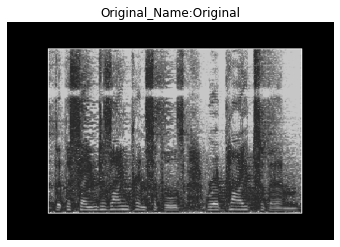

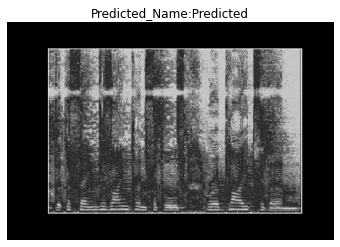

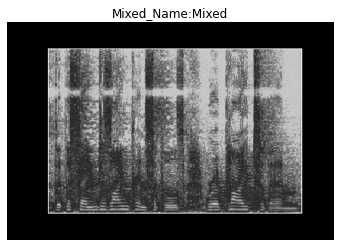

In [14]:
# initialize the figure
MSE_array={
	"mixed":[],
	"predicted":[]
}
SSIM_array={
	"mixed":[],
	"predicted":[]
}
fig = plt.figure("Images")
images = ("Original", image_dict["real"][0]), ("Predicted", image_dict["predicted"][0]), ("Mixed", image_dict["mixed"][0])
# loop over the images
#Show Images
for (i, (name, image)) in enumerate(images):
	# show the image
	plt.title(f"{name}_Name:{name}")
	plt.xlabel("Time")
	plt.ylabel("Frequency")
	plt.imshow(image, cmap = plt.cm.Greys)
	plt.axis("off")
	# show the figure
	plt.show()
	# cv2.imshow(name, image)

for i in range(len(image_dict["real"])):
	MSEmixed,SSIMmixed= compare_images(image_dict["real"][i], image_dict["mixed"][i], "Original vs. mixed")
	MSEpredicted,SSIMpredicted=compare_images(image_dict["real"][i], image_dict["predicted"][i], "Original vs. predicted")
	MSE_array["mixed"].append(MSEmixed)
	SSIM_array["mixed"].append(SSIMmixed)
	MSE_array["predicted"].append(MSEpredicted)
	SSIM_array["predicted"].append(SSIMpredicted)

df_MSE=pd.DataFrame()
df_SSIM=pd.DataFrame()

dict_aux={
	"aircrafts":[],
	"lluvia":[],
	"trafico":[],
	"viento":[]
}
    
for i,value in enumerate(MSE_array["mixed"]):

	if(i<=len(MSE_array["mixed"])/4-1):
		dict_aux["aircrafts"].append(value)
	elif(i>=len(MSE_array["mixed"])/4 and i<=((len(MSE_array["mixed"])/4)*2)-1):
		dict_aux["lluvia"].append(value)
	elif(i>=((len(MSE_array["mixed"])/4)*2) and i<((len(MSE_array["mixed"])/4)*3)-1):
		dict_aux["trafico"].append(value)
	else:
		dict_aux["viento"].append(value)

############
df_MSE.insert(0,"aircrafts_MSE_mixed",[mean(dict_aux["aircrafts"])])
df_MSE.insert(1,"aircrafts_MSE_desviacion",[desviacion(dict_aux["aircrafts"])])

df_MSE.insert(2,"lluvia_MSE_mixed",[mean(dict_aux["lluvia"])])
df_MSE.insert(3,"lluvia_MSE_desviacion",[desviacion(dict_aux["lluvia"])])

df_MSE.insert(4,"trafico_MSE_mixed",[mean(dict_aux["trafico"])])
df_MSE.insert(5,"trafico_MSE_desviacion",[desviacion(dict_aux["trafico"])])

df_MSE.insert(6,"viento_MSE_mixed",[mean(dict_aux["viento"])])
df_MSE.insert(7,"viento_MSE_desviacion",[desviacion(dict_aux["viento"])])

dict_aux={
	"aircrafts":[],
	"lluvia":[],
	"trafico":[],
	"viento":[]
}

for i,value in enumerate(MSE_array["predicted"]):

	if(i<=len(MSE_array["predicted"])/4-1):
		dict_aux["aircrafts"].append(value)
	elif(i>=len(MSE_array["predicted"])/4 and i<=((len(MSE_array["predicted"])/4)*2)-1):
		dict_aux["lluvia"].append(value)
	elif(i>=((len(MSE_array["predicted"])/4)*2) and i<((len(MSE_array["predicted"])/4)*3)-1):
		dict_aux["trafico"].append(value)
	else:
		dict_aux["viento"].append(value)

##################
df_MSE.insert(8,"aircrafts_MSE_predicted",[mean(dict_aux["aircrafts"])])
df_MSE.insert(9,"aircrafts_MSE_desviacionpre",[desviacion(dict_aux["aircrafts"])])

df_MSE.insert(10,"lluvia_MSE_predicted",[mean(dict_aux["lluvia"])])
df_MSE.insert(11,"lluvia_MSE_desviacionpre",[desviacion(dict_aux["lluvia"])])

df_MSE.insert(12,"trafico_MSE_predicted",[mean(dict_aux["trafico"])])
df_MSE.insert(13,"trafico_MSE_desviacionpre",[desviacion(dict_aux["trafico"])])

df_MSE.insert(14,"viento_MSE_predicted",[mean(dict_aux["viento"])])
df_MSE.insert(15,"viento_MSE_desviacionpre",[desviacion(dict_aux["viento"])])

dict_aux={
	"aircrafts":[],
	"lluvia":[],
	"trafico":[],
	"viento":[]
}

for i,value in enumerate(SSIM_array["mixed"]):

	if(i<=len(SSIM_array["mixed"])/4-1):
		dict_aux["aircrafts"].append(value)
	elif(i>=len(SSIM_array["mixed"])/4 and i<=((len(SSIM_array["mixed"])/4)*2)-1):
		dict_aux["lluvia"].append(value)
	elif(i>=((len(SSIM_array["mixed"])/4)*2) and i<((len(SSIM_array["mixed"])/4)*3)-1):
		dict_aux["trafico"].append(value)
	else:
		dict_aux["viento"].append(value)


df_SSIM.insert(0,"aircrafts_SSIM_mixed",[mean(dict_aux["aircrafts"])])
df_SSIM.insert(1,"aircrafts_SSIM_desviacion",[desviacion(dict_aux["aircrafts"])])

df_SSIM.insert(2,"lluvia_SSIM_mixed",[mean(dict_aux["lluvia"])])
df_SSIM.insert(3,"lluvia_SSIM_desviacion",[desviacion(dict_aux["lluvia"])])

df_SSIM.insert(4,"trafico_SSIM_mixed",[mean(dict_aux["trafico"])])
df_SSIM.insert(5,"trafico_SSIM_desviacion",[desviacion(dict_aux["trafico"])])

df_SSIM.insert(6,"viento_SSIM_mixed",[mean(dict_aux["viento"])])
df_SSIM.insert(7,"viento_SSIM_desviacion",[desviacion(dict_aux["viento"])])

dict_aux={
	"aircrafts":[],
	"lluvia":[],
	"trafico":[],
	"viento":[]
}

for i,value in enumerate(SSIM_array["predicted"]):

	if(i<=len(SSIM_array["predicted"])/4-1):
		dict_aux["aircrafts"].append(value)
	elif(i>=len(SSIM_array["predicted"])/4 and i<=((len(SSIM_array["predicted"])/4)*2)-1):
		dict_aux["lluvia"].append(value)
	elif(i>=((len(SSIM_array["predicted"])/4)*2) and i<((len(SSIM_array["predicted"])/4)*3)-1):
		dict_aux["trafico"].append(value)
	else:
		dict_aux["viento"].append(value)

df_SSIM.insert(8,"aircrafts_SSIM_predicted",[mean(dict_aux["aircrafts"])])
df_SSIM.insert(9,"aircrafts_SSIM_desviacionpre",[desviacion(dict_aux["aircrafts"])])

df_SSIM.insert(10,"lluvia_SSIM_predicted",[mean(dict_aux["lluvia"])])
df_SSIM.insert(11,"lluvia_SSIM_desviacionpre",[desviacion(dict_aux["lluvia"])])

df_SSIM.insert(12,"trafico_SSIM_predicted",[mean(dict_aux["trafico"])])
df_SSIM.insert(13,"trafico_SSIM_desviacionpre",[desviacion(dict_aux["trafico"])])

df_SSIM.insert(14,"viento_SSIM_predicted",[mean(dict_aux["viento"])])
df_SSIM.insert(15,"viento_SSIM_desviacionpre",[desviacion(dict_aux["viento"])])


In [15]:
df_MSE

,aircrafts_MSE_mixed,aircrafts_MSE_desviacion,lluvia_MSE_mixed,lluvia_MSE_desviacion,trafico_MSE_mixed,trafico_MSE_desviacion,viento_MSE_mixed,viento_MSE_desviacion,aircrafts_MSE_predicted,aircrafts_MSE_desviacionpre,lluvia_MSE_predicted,lluvia_MSE_desviacionpre,trafico_MSE_predicted,trafico_MSE_desviacionpre,viento_MSE_predicted,viento_MSE_desviacionpre
0,1628.499279,1246.645942,1867.937053,1100.685313,1329.707988,1139.699892,683.605141,541.939411,680.215749,323.055297,698.913153,267.743326,609.202322,349.162612,429.248915,174.911717


In [16]:
df_SSIM

,aircrafts_SSIM_mixed,aircrafts_SSIM_desviacion,lluvia_SSIM_mixed,lluvia_SSIM_desviacion,trafico_SSIM_mixed,trafico_SSIM_desviacion,viento_SSIM_mixed,viento_SSIM_desviacion,aircrafts_SSIM_predicted,aircrafts_SSIM_desviacionpre,lluvia_SSIM_predicted,lluvia_SSIM_desviacionpre,trafico_SSIM_predicted,trafico_SSIM_desviacionpre,viento_SSIM_predicted,viento_SSIM_desviacionpre
0,0.617308,0.125709,0.578077,0.084843,0.628209,0.112796,0.731103,0.110797,0.625725,0.101243,0.607515,0.075456,0.643781,0.089163,0.728722,0.076905
